<a href="https://colab.research.google.com/github/nellyiya/CHATBOT/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This chatbot is designed specifically for the agriculture domain. It serves as a virtual assistant for farmers and agricultural workers, providing accurate and timely information about crops, soil health, pest management, and sustainable farming practices. The chatbot helps address the knowledge gap many farmers face due to limited access to experts and resources.

By offering real-time advice, weather updates, and actionable tips, the chatbot empowers users to make informed decisions that improve crop yields and reduce losses. It simplifies complex agricultural knowledge into easy-to-understand guidance accessible anytime via chat.

The relevance of this chatbot lies in its ability to support farmers in remote or underserved areas, where traditional agricultural extension services are scarce or inefficient. Ultimately, this chatbot enhances agricultural productivity, promotes sustainable practices, and contributes positively to food security and rural livelihoods.

Additionally, this chatbot consistently uses a short Q&A style for communication. This means it provides concise, direct answers rather than lengthy explanations, making information quick and easy to grasp. This style ensures that farmers can quickly get the help they need without confusion or delay.

I developed this chatbot because farmers need reliable, round-the-clock assistance, and this tool helps fill that crucial gap with scalable, efficient support.



The KisanVaani agriculture QA dataset contains question-answer pairs focused on practical farming topics. It provides concise, real-world agricultural advice in English. This dataset is ideal for training chatbots that deliver clear, actionable farming tips to support farmers with quick, easy-to-understand guidance.

In [14]:
# Cell 2: Import libraries and load dataset

import tensorflow as tf
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt



In [17]:
# Cell 2: Import libraries and load dataset

import tensorflow as tf
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os

# Load the dataset from Hugging Face Hub
dataset = load_dataset("KisanVaani/agriculture-qa-english-only", split='train')

print(f"Total samples in dataset: {len(dataset)}")
print(dataset[0])



Total samples in dataset: 22615
{'question': 'why is crop rotation important in farming?', 'answers': 'This helps to prevent soil erosion and depletion, and can also help to control pests and diseases'}


In [19]:
# Convert to pandas DataFrame for cleaning
df = pd.DataFrame(dataset)

# Dataset Cleaning:
# 1. Remove duplicate rows
df = df.drop_duplicates()

# 2. Handle missing values - drop rows with missing values as example
df = df.dropna()

# 3. Standardize string columns to lowercase if applicable
# Example: If you have a 'question' column
df['question'] = df['question'].str.lower()

# 4. Remove outliers (if numerical columns exist, adjust names)
# Example below assumes numeric columns are present
if len(df.select_dtypes(include=[np.number]).columns) > 0:
    z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
    df = df[(z_scores < 3).all(axis=1)]

print(f"Samples after cleaning: {len(df)}")

# Convert cleaned DataFrame back to Hugging Face dataset if needed
from datasets import Dataset
cleaned_dataset = Dataset.from_pandas(df)

# Save cleaned dataset as CSV in 'data' folder
os.makedirs('data', exist_ok=True)
df.to_csv('data/cleaned_agri_dataset.csv', index=False)

print("Cleaned dataset saved to data/cleaned_agri_dataset.csv")


Samples after cleaning: 2331
Cleaned dataset saved to data/cleaned_agri_dataset.csv


This code splits the dataset into training and validation sets using an 80-20 ratio with a fixed random seed for reproducibility.and cleans the dataset

In [20]:
# Cell 3: Prepare train and validation splits using datasets library

split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

train_data = split_dataset['train']
val_data = split_dataset['test']

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Convert to pandas DataFrames for saving
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# Save to data folder
os.makedirs('data', exist_ok=True)
train_df.to_csv('data/train_split.csv', index=False)
val_df.to_csv('data/val_split.csv', index=False)

print("Train and validation splits saved to data/train_split.csv and data/val_split.csv respectively.")


Training samples: 18092
Validation samples: 4523
Train and validation splits saved to data/train_split.csv and data/val_split.csv respectively.


# Cell 4: Load tokenizer and define preprocessing
The code defines how to load a T5 tokenizer, preprocess data by tokenizing questions and answers, shift decoder tokens, and prepare datasets for training with the T5 model, which is an encoder-decoder transformer for NLP tasks

In [21]:
# Cell 4: Load tokenizer and define preprocessing

MODEL_NAME = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

MAX_LEN_INPUT = 64
MAX_LEN_OUTPUT = 64

def shift_tokens_right(input_ids, pad_token_id, decoder_start_token_id):
    shifted_input_ids = np.zeros_like(input_ids)
    shifted_input_ids[:, 0] = decoder_start_token_id
    shifted_input_ids[:, 1:] = input_ids[:, :-1]
    shifted_input_ids[input_ids == pad_token_id] = pad_token_id
    return shifted_input_ids.tolist()

def preprocess_function(examples):
    inputs = ["question: " + q for q in examples["question"]]
    targets = examples["answers"]  # or 'answer' based on your dataset
    model_inputs = tokenizer(inputs, max_length=MAX_LEN_INPUT, truncation=True, padding="max_length")

    labels = tokenizer(targets, max_length=MAX_LEN_OUTPUT, truncation=True, padding="max_length")
    labels_ids = labels["input_ids"]

    labels_ids = [[-100 if token == tokenizer.pad_token_id else token for token in label] for label in labels_ids]
    model_inputs["labels"] = labels_ids

    decoder_input_ids = shift_tokens_right(
        np.array(labels["input_ids"]),
        pad_token_id=tokenizer.pad_token_id,
        decoder_start_token_id=tokenizer.pad_token_id
    )
    model_inputs["decoder_input_ids"] = decoder_input_ids

    return model_inputs

train_dataset = train_data.map(preprocess_function, batched=True)
val_dataset = val_data.map(preprocess_function, batched=True)

train_dataset.set_format(type="tensorflow", columns=['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])
val_dataset.set_format(type="tensorflow", columns=['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/18092 [00:00<?, ? examples/s]

Map:   0%|          | 0/4523 [00:00<?, ? examples/s]

I  used Hugging Face’s datasets and tokenizer to prepare my data, then converting it into TensorFlow datasets for smooth integration with TensorFlow training. This way, I can efficiently feed batches of tokenized text and labels into my model during training. It helps me combine Hugging Face’s flexible preprocessing with TensorFlow’s powerful training pipeline in just a few steps.

In [22]:
# Cell 5: Convert Hugging Face datasets to tf.data.Dataset, including decoder_input_ids

def to_tf_dataset(hf_dataset):
    features = {
        "input_ids": np.array(hf_dataset["input_ids"]),
        "attention_mask": np.array(hf_dataset["attention_mask"]),
        "decoder_input_ids": np.array(hf_dataset["decoder_input_ids"]),
    }
    labels = np.array(hf_dataset["labels"])
    return tf.data.Dataset.from_tensor_slices((features, labels))

batch_size = 8

tf_train_dataset = to_tf_dataset(train_dataset).shuffle(100).batch(batch_size)
tf_val_dataset = to_tf_dataset(val_dataset).batch(batch_size)

print("Training dataset batches:", tf_train_dataset)
print("Validation dataset batches:", tf_val_dataset)


Training dataset batches: <_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'decoder_input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>
Validation dataset batches: <_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'decoder_input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>


I loaded the pretrained T5 model using TensorFlow and initialize the Adam optimizer. Then, I compile the model with a custom loss that ignores padding tokens, preparing it for training.

In [23]:
# Cell 6: Load model and compile

model = TFT5ForConditionalGeneration.from_pretrained(MODEL_NAME, from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

def masked_loss(y_true, y_pred):
    pad_token_id = tf.constant(tokenizer.pad_token_id, dtype=y_true.dtype)
    y_true_safe = tf.where(y_true == -100, pad_token_id, y_true)
    loss_ = tf.keras.losses.sparse_categorical_crossentropy(y_true_safe, y_pred, from_logits=True)
    mask = tf.cast(tf.not_equal(y_true, -100), dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


model.compile(optimizer=optimizer, loss=masked_loss)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


I train the model for 3 epochs using the TensorFlow training and validation datasets. Then, I plot the training and validation loss curves to monitor the model’s performance over time.

Epoch 1/3
2262/2262 [==============================] - 313s 119ms/step - loss: 2.5161 - val_loss: 1.1990
Epoch 2/3
2262/2262 [==============================] - 265s 117ms/step - loss: 1.2623 - val_loss: 0.5206
Epoch 3/3
2262/2262 [==============================] - 281s 124ms/step - loss: 0.7297 - val_loss: 0.3458


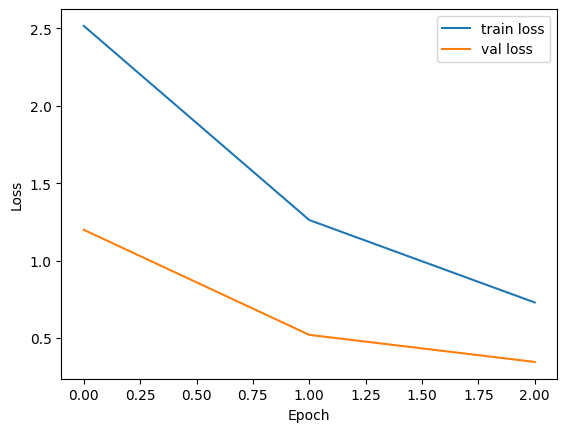

In [24]:
# Cell 7: Train model

epochs = 3

history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=epochs)

# Plot training/validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


saving model and tokenizer

In [25]:
# Cell 8: Save model and tokenizer

model.save_pretrained("./agri_chatbot_t5")
tokenizer.save_pretrained("./agri_chatbot_t5")


('./agri_chatbot_t5/tokenizer_config.json',
 './agri_chatbot_t5/special_tokens_map.json',
 './agri_chatbot_t5/spiece.model',
 './agri_chatbot_t5/added_tokens.json')

In [26]:
# Cell 9: Define inference function and test

def generate_answer(question, max_length=64):
    input_text = "question: " + question
    input_ids = tokenizer.encode(input_text, return_tensors="tf", max_length=MAX_LEN_INPUT, truncation=True, padding="max_length")
    outputs = model.generate(input_ids, max_length=max_length, num_beams=5, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

test_question = "what is organic farming?"
print("Q:", test_question)
print("A:", generate_answer(test_question))


Q: what is organic farming?
A: refers to the process by which plants obtain and utilize essential nutrients for growth and development.


In [27]:
question = "what is fertilizers?"
answer = generate_answer(question)
print("Q:", question)
print("A:", answer)


Q: what is fertilizers?
A: Fertilizers are substances that are added to soil to improve the growth and quality of crops


In [30]:
!pip install nbstripout
!nbstripout Notebook.ipynb


Could not strip 'Notebook.ipynb': file not found


In [37]:
!cp /content/Notebook.ipynb /content/TempNotebook.ipynb
!pip install nbstripout
!nbstripout /content/TempNotebook.ipynb


In [38]:
from google.colab import files
uploaded = files.upload()  # select Notebook.ipynb from your computer


Saving Notebook.ipynb to Notebook (1).ipynb


In [39]:
!cp /content/Notebook.ipynb /content/TempNotebook.ipynb


In [40]:
!nbstripout /content/TempNotebook.ipynb
